In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import cv2
import numpy as np
import os
from math import floor
from keras.preprocessing import image
import skimage.feature as sf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Convolution3D, MaxPooling3D
import keras.optimizers as opt
from keras.utils import np_utils, generic_utils
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import train_test_split
from keras.models import load_model

import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD

from sklearn import preprocessing
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [ ]:
def load_data(num_vids, num_frames):
  
  parent_dir = '/content/drive/Shareddrives/Projects/Fall 2020 Projects/RusLan'
  parent_dir = os.path.abspath(parent_dir)
  
  frames_list = []
  Xtr=[]
  labels=[]
  vid_count = 0
  frame_count = 0
  
  act_classes=['Bird','Cat','Dad', 'Look', 'Me', 'Mom', 'Woman','Pipe']

  for act_class in act_classes:
    vid_count = 0
    class_dir = os.path.join(parent_dir, act_class)
    vid_list = []
    for vid_file in os.listdir(class_dir):
      vid_count += 1
      if (vid_count<=num_vids):
        frames_list = []

        file = os.path.join(class_dir,vid_file)
        vid_cap = cv2.VideoCapture(file)
        length = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print ("IN: ",act_class, vid_file, vid_count)
        skipframes = floor(length/num_frames) - 1

        success , frame = vid_cap.read()
        frame_count = 1

        #remove empty frames
        while success and frame_count<=num_frames:
          norm = cv2.normalize(frame, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          resized = cv2.resize(norm, (64,64), interpolation = cv2.INTER_AREA)
          resized=np.array(resized)
          x=resized.reshape((1,3,64,64))
          frames_list.append(x)
          frame_count += 1
          
          for skip in range (0, skipframes):
            success , frame = vid_cap.read()
          while not success:
            success , frame = vid_cap.read()
        if frame_count!=(num_frames+1):
          print( vid_file, frame_count)

        Xtr.append(frames_list)
        labels.append(act_class)
  return Xtr,labels

In [ ]:
def feature_extractor():
  model = models.mobilenet_v2(pretrained=True)
  new_base = nn.Sequential(*list(model.classifier.children())[:-1])
  return new_base

def extract_features(Xtr,new_base):
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)
      output= new_base[:3](x)
      j=output
  return Xtr

In [ ]:
def preprocess(labels,Xtr, nb_classes):

  y=np.zeros(len(labels))
  act_classes=['Bird','Cat','Dad', 'Look', 'Me', 'Mom', 'Woman','Pipe']

  for i in range (0, len(y)):
    if labels[i] in act_classes:
      y[i]=act_classes.index(labels[i])
  
  # convert class vectors to binary class matrices
  Y_train = np_utils.to_categorical(y, nb_classes)
  
  Xtr_new=np.array(len(Xtr))
  Xtr_new=np.array(Xtr)
  print("Current shape:", Xtr_new.shape)
  Xtr_new=Xtr_new.reshape(160,3,10,64,64)
  print("New shape:", Xtr_new.shape)
  return Xtr_new,Y_train

In [ ]:
# Define model
def kerasmod3():

  model = Sequential()
  model.add(BatchNormalization())

  model.add(Convolution3D(8, 5, input_shape=(3,10,64,64), activation='relu', data_format = 'channels_first'))
  model.add(Convolution3D(16, 3, activation='relu'))
  model.add(Convolution3D(32, 3, activation='relu'))

  model.add(Dropout(0.1))
  model.add(MaxPooling3D(pool_size=2))
  

  model.add(Dropout(0.1))

  model.add(Flatten())
  
  model.add(Dropout(0.1))

  model.add(Dense(128, kernel_initializer='normal', activation='relu'))

  model.add(Dense(8, kernel_initializer='normal'))

  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

  return model

In [ ]:
def main():

  act_classes=['Bird','Cat','Dad', 'Look', 'Me', 'Mom', 'Woman','Pipe']
  num_vids=20
  num_frames=10

  nb_classes =8
  #loading and preprocessing
  X,labels=load_data(num_vids, num_frames)
 
  new_base=feature_extractor()
  Xtr=extract_features(X,new_base)

  Xtr_new, Y_train=preprocess(labels,Xtr,nb_classes)  
  
  # CNN Training parameters

  X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,Y_train, 
                                                                    test_size=0.2, random_state=13)

  # Train the model
  #model=kerasmod3()

  #hist = model.fit(X_train_new, y_train_new, batch_size=  15, epochs = 30,shuffle=True)
  #hist = model.fit(X_train_new, y_train_new, batch_size=32,epochs=20,validation_split=0.2, shuffle=True)
  model= load_model('/content/drive/Shareddrives/Projects/Fall 2020 Projects/DL/RusLan_model 75%.h5')

  # Evaluate the model
  score = model.evaluate(X_val_new, y_val_new, batch_size=15)
  print('Test score:', score[0])
  print('Test accuracy:', score[1]) 
  #model.save("RusLan_model.h5")
  y_val_new1 = [np.argmax(y, axis=None, out=None) for y in y_val_new]
  y_pred=model.predict_classes(X_val_new)
  

  con_mat = tf.math.confusion_matrix(labels=y_val_new1, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
  print(con_mat_df)
  print(classification_report(y_val_new1,y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

IN:  Bird 59 1.mp4 1
IN:  Bird 59 2.mp4 2
IN:  Bird 59 3.mp4 3
IN:  Bird 59 4.mp4 4
IN:  Bird 58 1.mp4 5
IN:  Bird 58 2.mp4 6
IN:  Bird 58 3.mp4 7
IN:  Bird 58 4.mp4 8
IN:  Bird 57 1.mp4 9
IN:  Bird 57 2.mp4 10
IN:  Bird 57 3.mp4 11
IN:  Bird 57 4.mp4 12
IN:  Bird 56 1.mp4 13
IN:  Bird 56 2.mp4 14
IN:  Bird 56 3.mp4 15
IN:  Bird 56 4.mp4 16
IN:  Bird 42 1.mp4 17
IN:  Bird 42 2.mp4 18
IN:  Bird 42 3.mp4 19
IN:  Bird 42 4.mp4 20
IN:  Cat 58 1.mp4 1
IN:  Cat 58 2.mp4 2
IN:  Cat 58 3.mp4 3
IN:  Cat 58 4.mp4 4
IN:  Cat 40 1.mp4 5
IN:  Cat 40 2.mp4 6
IN:  Cat 40 3.mp4 7
IN:  Cat 40 4.mp4 8
IN:  Cat 57 1.mp4 9
IN:  Cat 57 2.mp4 10
IN:  Cat 57 3.mp4 11
IN:  Cat 57 4.mp4 12
IN:  Cat 44 2.mp4 13
IN:  Cat 44 3.mp4 14
IN:  Cat 44 1.mp4 15
IN:  Cat 44 4.mp4 16
IN:  Cat 59 1.mp4 17
IN:  Cat 59 2.mp4 18
IN:  Cat 59 3.mp4 19
IN:  Cat 59 4.mp4 20
IN:  Dad 54 1.mp4 1
IN:  Dad 54 2.mp4 2
IN:  Dad 54 3.mp4 3
IN:  Dad 54 4.mp4 4
IN:  Dad 4 1.mp4 5
IN:  Dad 4 2.mp4 6
IN:  Dad 4 3.mp4 7
IN:  Dad 4 4.mp4 8
IN

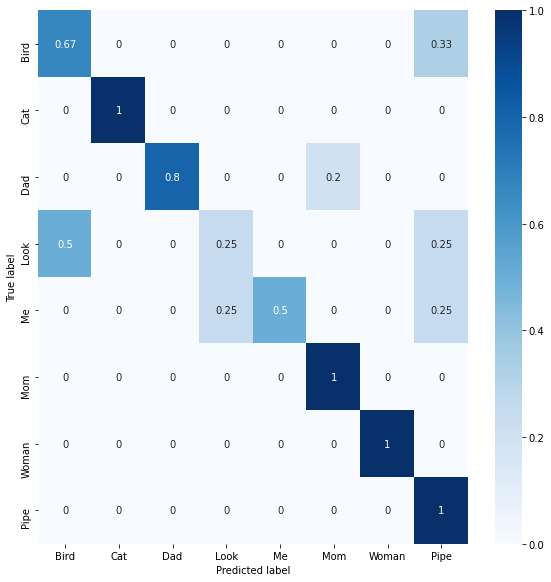

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
